# Estimating Recombination Probabilities

Made by: Sarah Odell

github: https://github.com/sarahodell

Using the maize genetic map (<a href='https://www.nature.com/articles/hdy2014123'>Ogut et al. 2015</a>), approximate recombination probabilities for evenly distributed regions across the chromosome (using chromosome 10 in this example). These recombination probabilities will be used as a probability distribution to to simulate crossovers


In [6]:
%pylab inline
import pandas as pd

import  time
import  platform
print('Last updated: %s' %time.strftime('%d/%m/%Y'))
print('Created using Python', platform.python_version())

Populating the interactive namespace from numpy and matplotlib
Last updated: 19/06/2018
('Created using Python', '2.7.13')


Read in the the raw genetic map 'ogut_fifthcM_map_agpv3.txt' and pull out chromosome 10. We also want to edit the marker names so they match with the format of the marker names in our vcf files.

In [ ]:
gmap = pd.read_table('ogut_fifthcM_map_agpv3.txt',sep='\t',header=None,
                     names=['SNP_ID','SNP_newID','chr','pos','cM'],
                     dtype={'SNP_ID':str,'SNP_newID':str,'chr':str,'pos':str,'cM':float})
c10gmap = gmap[gmap['chr']=='10']
c10gmap=c10gmap.reset_index()
c10gmap.head()

In [ ]:
snps=[]
for index,row in c10gmap.iterrows():
    new_row = 'S10_'+row['SNP_ID'].split('_')[1]
    snps.append(new_row)
c10gmap['SNP_ID']=snps

ogut = c10gmap[['SNP_ID','chr','pos','cM']]
ogut=ogut.dropna(axis=0)
ogut.to_csv('ogut_map.csv',sep=',',index=False)

Now that we have our genetic map formatted in the way we want it, let's calculate recombination probabilities. I'm going to do this first by scaling the genetic positions so they start at zero. Then I calculate the genetic and physical distance between each marker and set the crossover probability for the region between a marker and its next neighbor as genetic distance/physical distance.

Next, for each adjacent marker pair, I make a linear model regressing crossover probability on physical distance. For a set number of equally spaced physical positions between the two markers, I use the model to predict crossover probability. Then, I set all these predicted values so that they sum to one and voila! a quasi-biologically accurate probability distribution of recombination on chromosome 10. 

In [8]:
ogutmap=pd.read_table('ogut_map.csv',sep=',')
ogutmap['cM']=pd.to_numeric(ogutmap['cM'])
ogutmap.head()

,SNP_ID,chr,pos,cM
0,S10_620779,10,620679,-6.4
1,S10_679925,10,679825,-6.2
2,S10_739071,10,738971,-6.0
3,S10_798217,10,798117,-5.8
4,S10_857362,10,857262,-5.6


In [9]:
#Set the genetic map to start at 0 
ogutmap['cM_scaled1']=(ogutmap['cM']+6.4)
plast = 0
clast = 0
pdists=[]
cdists=[]
# Calculated the genetic distance between markers
for index,row in ogutmap.iterrows():
    pdist = row['pos']-plast
    cdist=row['cM_scaled1']-clast
    pdists.append(pdist)
    cdists.append(cdist)
    plast=row['pos']
    clast=row['cM_scaled1']
ogutmap['pdists']=pdists
ogutmap['cdists']=cdists
#Make them sum to one
ogutmap['xo_prob']=ogutmap['cdists']/ogutmap['pdists']

In [10]:
ogutmap.head()

,SNP_ID,chr,pos,cM,cM_scaled1,pdists,cdists,xo_prob
0,S10_620779,10,620679,-6.4,0.0,620679,0.0,0.000000
1,S10_679925,10,679825,-6.2,0.2,59146,0.2,0.000003
2,S10_739071,10,738971,-6.0,0.4,59146,0.2,0.000003
3,S10_798217,10,798117,-5.8,0.6,59146,0.2,0.000003
4,S10_857362,10,857262,-5.6,0.8,59145,0.2,0.000003


In [5]:
from scipy import stats

In [31]:
x = []
y = []
start = 0 
end = 150000000
mi = min(ogutmap['pos'])
mx = max(ogutmap['pos'])
for index,row in ogutmap.iterrows():
    if row['pos'] == mi:
        xpoints=[start,row['pos']]
        ypoints=[0.000003,row['xo_prob']]
    elif row['pos'] == mx:
        xpoints=[row['pos'],end]
        ypoints=[row['xo_prob'],0.000003]
    else:
        xpoints=[last['pos'],row['pos']]
        ypoints=[last['xo_prob'],row['xo_prob']]
    slope,intercept,r_value,p_value,stderr = stats.linregress(xpoints,ypoints)
    for i in range(xpoints[0],xpoints[1],10000):
        x.append(i)
        y.append(round(abs(slope*i + intercept),9))
    last=row

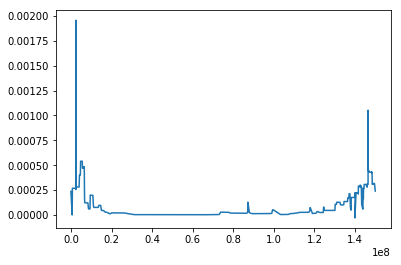

In [13]:
plot(x,ydelta)

Now let's write this out to a file so we can use it later

In [32]:
xy = {"pos":x,"xo":y}
recomb = pd.DataFrame(xy)
recomb['xo_prob'] = recomb['xo']/sum(recomb['xo'])
recomb.head()

,pos,xo,xo_prob
0,0,0.000003,0.000238
1,10000,0.000003,0.000234
2,20000,0.000003,0.000230
3,30000,0.000003,0.000227
4,40000,0.000003,0.000223


In [33]:
sum(recomb['xo_prob'])

0.99999999999998

In [ ]:
recomb.to_csv('recomb_prob_est.csv',index=False,sep='\t')